### 검증 세트
테스트 세트를 사용하지 않고 모델을 평가하는 데이터

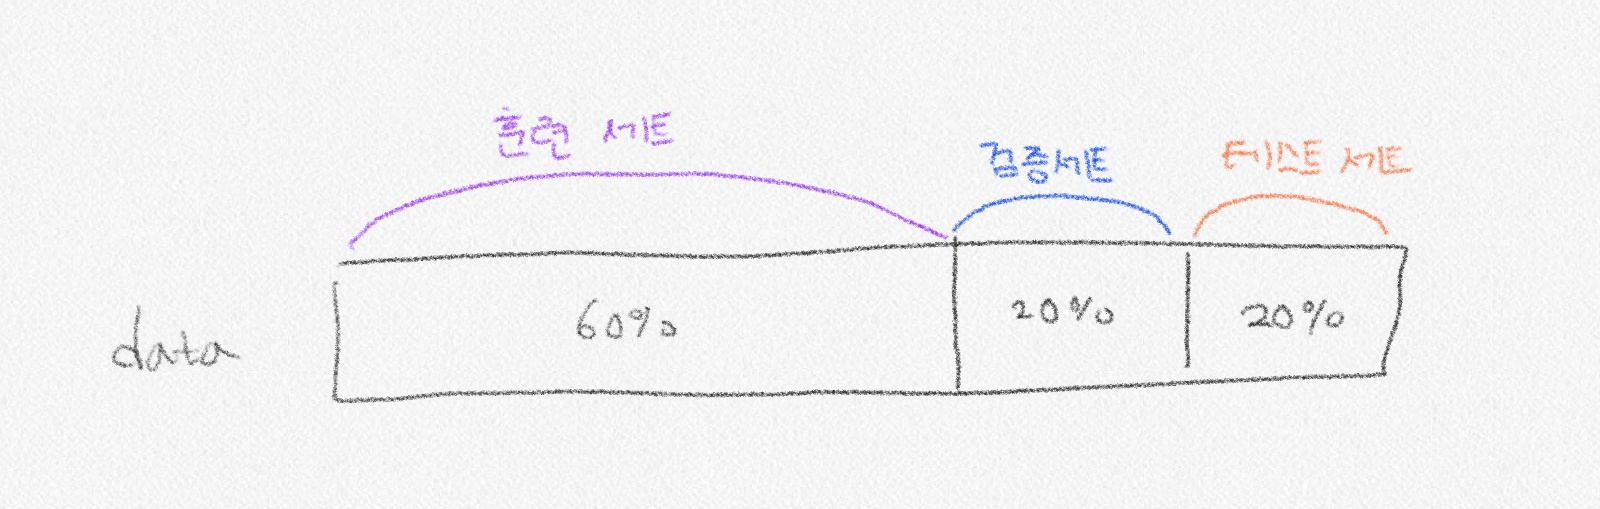

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split 

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [4]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


### 교차 검증
검증 세트를 떼어 평가하는 과정을 반복하고, 평가 점수를 평균한다.
- 안정적인 검증 점수를 얻고, 훈련에 더 많은 데이터 사용 가능

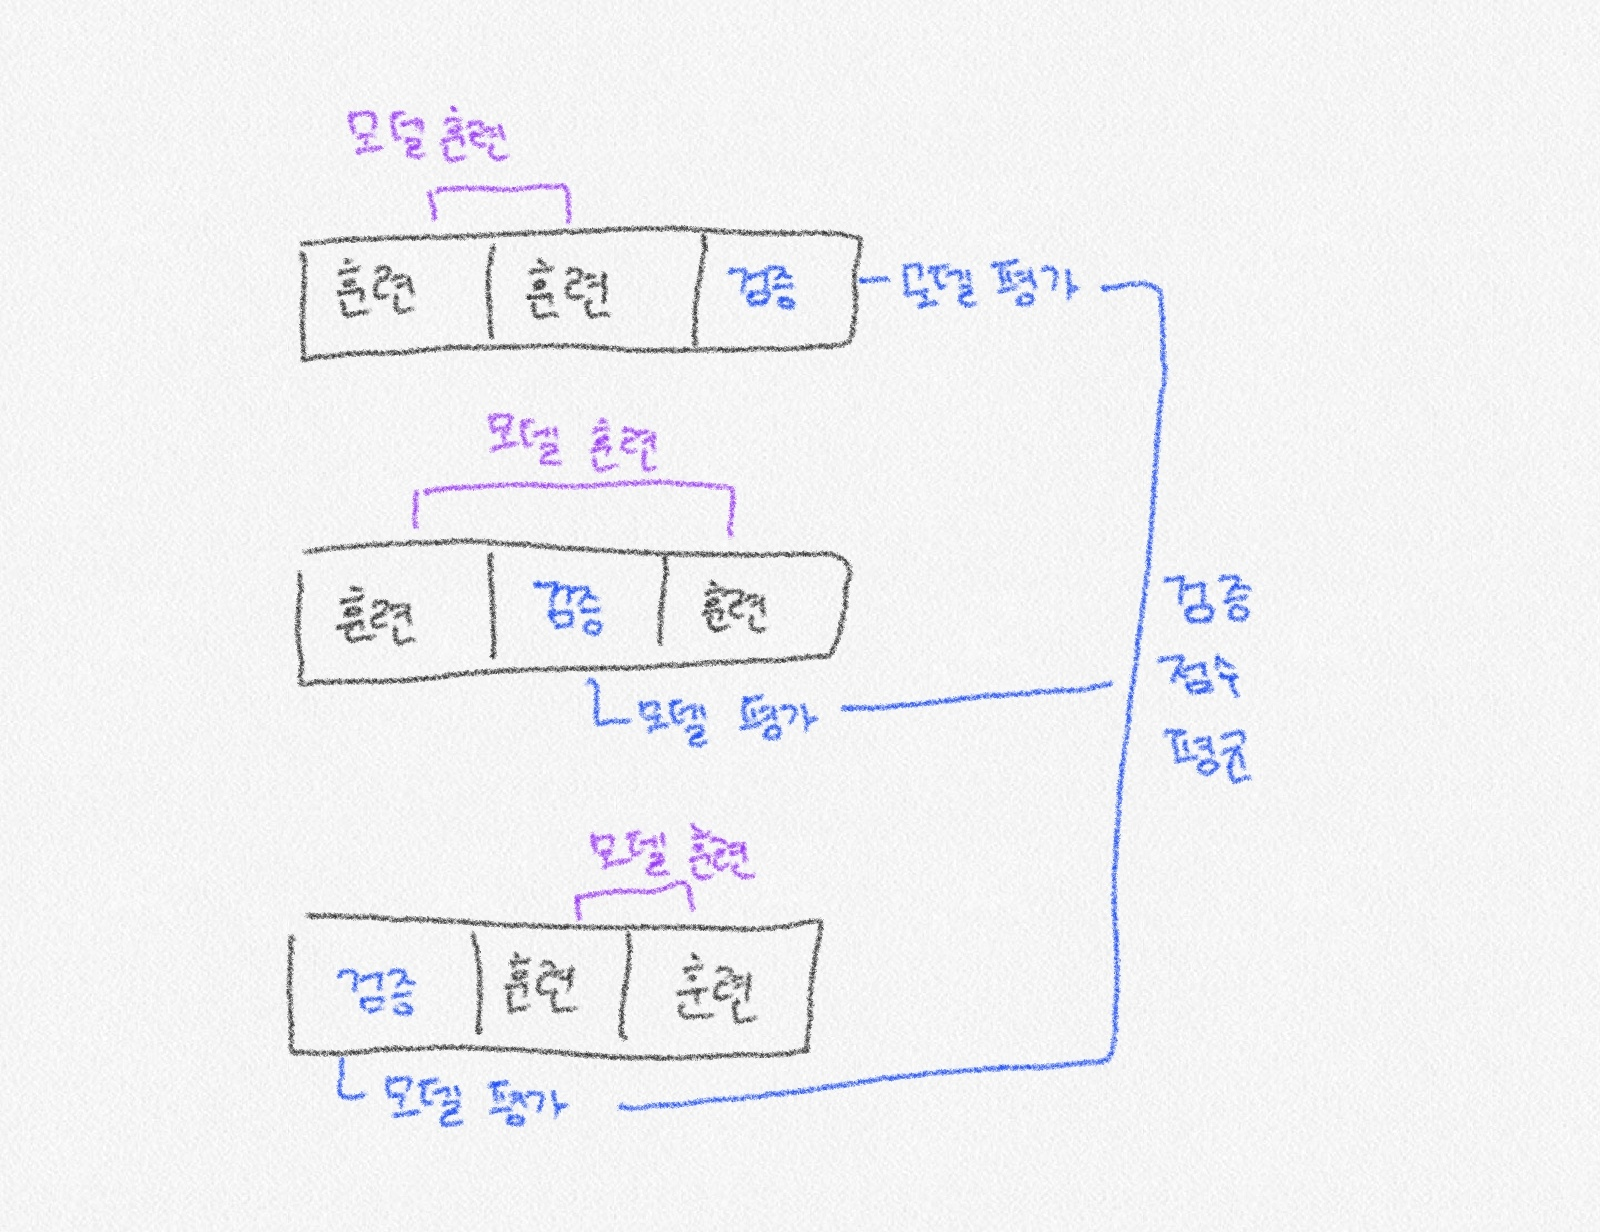

In [5]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)

print(scores)

{'fit_time': array([0.01175714, 0.00876832, 0.00888586, 0.00812316, 0.0080235 ]), 'score_time': array([0.00094724, 0.00105572, 0.0007844 , 0.00078034, 0.00080252]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [6]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


### 분할기를 사용한 교차 검증
- cross_validate() 함수는 기본적으로 5폴드 교차 검증을 수행하지만    
cv 매개변수를 통해 폴드 수를 변경할 수 있다.
- 분할기를 사용하여 데이터를 섞은 후 교차 검증을 한다.    
`cv = KFold/StratifiedKFold`

> 분류 모델 : StratifiedKFold    
> 회귀 모델 : KFold

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


`StartifiedKFold(n_splits=10)` : 10 폴드로 교차 검증을 한다.

In [9]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 그리드 서치
교차 검증의 기능도 하고, 여러개의 매개변수를 바꿔가면서 교차검증을 할 수 있게 해준다.

params에 min_impurity_decrease을 지정하므로써 트리의 성장을 막는다.
> min_impurity_decrease : 불손도의 감소율 최솟값





In [10]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV(결정트리 개체, 파라미터, n_jobs=-1)`    
n_jobs :  병렬 실행에 사용할 cpu 코어 개수 지정. (-1 : 모든 코어 사용)

In [11]:
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [12]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [13]:
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'])

{'min_impurity_decrease': 0.0001}
[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


### 확률 분포 선택

In [14]:
from scipy.stats import uniform, randint

In [15]:
rgen = randint(0, 10)
rgen.rvs(10)

array([2, 5, 3, 0, 9, 8, 0, 1, 1, 1])

In [16]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([106, 113,  99,  99,  95, 108, 103,  94,  93,  90]))

In [17]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.04329412, 0.0698182 , 0.88856842, 0.7792435 , 0.72996383,
       0.04044223, 0.60563512, 0.87004223, 0.1556748 , 0.08733267])

### 랜덤 서치
매개변수를 샘플링할 수 있는 확률 분포 객체로 전달

In [18]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(20, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25)
          }

In [19]:
from sklearn.model_selection import RandomizedSearchCV

n_iter 범위 안에서 샘플링한다.

In [20]:
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4c49a65110>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4c49aa2410>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4c49a655d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4c49a65d10>},
                   random_state=42)

In [21]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [22]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [23]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86
